# Scattering cross-section calculation

To run this notebook from your browser, click [this link](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FNear2FarSphereRCS.ipynb).

This tutorial will show you how to compute the radar cross section (RCS) for a dielectric sphere by sampling scattered near fields on a closed surface surrounding the sphere, and transforming them to observation points far away.

This example demonstrates the usefulness of the near field to far field transformation for reducing the simulation size needed for structures involving lots of empty space.

To obtain the scattered field, we will run two simulations:
* one with the sphere to compute the total near field on a closed surface around the sphere, and
* one without the sphere, to compute just the incident field and subtract it from the above to get the scattered field.

Then, we'll show how to use a near-field to far-field transformation in `Tidy3D` to compute the RCS for the sphere either on the cloud during the simulation run, or on your local machine afterwards.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

## Define Simulation Parameters

We first need to define our simulation parameters and the structure.

In [2]:
# radius and location of the sphere
radius = 0.5
center = [0, 0, 0]

# permittivity of the sphere
epsr = 4

# free space central wavelength
wavelength = (2.0 * radius) / 2.0
f0 = td.C_0 / wavelength

# distance between the surface of the sphere and the start of the PML layers along each cartesian direction
buffer_PML = 3 * wavelength

# distance between the sphere and the near field monitor along each cartesian direction
buffer_mon = 1 * wavelength

# Define material properties
air = td.Medium(permittivity=1)
diel = td.Medium(permittivity=epsr)

# resolution control
min_steps_per_wvl = 15

# create the sphere
sphere = td.Structure(geometry=td.Sphere(center=center, radius=radius), medium=diel)
geometry = [sphere]

# define PML layers on all sides
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

# set the domain size in x, y, and z
domain_size = buffer_PML + 2 * radius + buffer_PML

# construct simulation size array
sim_size = (domain_size, domain_size, domain_size)

## Create Source

For our incident field, we create a plane wave incident from below the sphere polarized in the x direction.

In [3]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, offset=offset)

# place the source below the sphere, propagating in the +z direction
source = td.PlaneWave(
    center=(0,0,-(radius + 3 * buffer_PML / 4)),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    direction='+',
    pol_angle=0)

# Simulation run time past the source decay (around t=2*offset/fwidth)
run_time = 100 / fwidth


## Create Monitors

Next, we define the monitors that will capture the near field data.

First, we create a [FieldMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html?highlight=FielDmonitor) completely enclosing the sphere, using the `.surfaces()` method to extract the 6 planar surfaces surrounding the volume. This cuts down on the data required vs computing the full volume because only the fields on the enclosing surface are required to get the far field information.

The near fields will be captured on these surfaces, and after the simulation will be used to compute far fields on your local machine.

In [4]:
# create a set of surface monitors around the sphere for local computation of far fields
mon_size = 2 * radius + 2 * buffer_mon
monitors_near = td.FieldMonitor.surfaces(
    center=center,
    size=[mon_size, mon_size, mon_size],
    freqs=[f0],
    name='near_field')

Next, we'll make a [Near2FarAngleMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.Near2FarAngleMonitor) which is used for computing far-fields directly on the server during the simulation run with `Tidy3D`'s full hardware optimization, making it extremely fast. Note that in this case, `surfaces()` must not be used because the solver already knows to use only surface tangential fields to compute the far fields.

With this approach, the near-field data associated with the monitor is used to compute the far fields, and only the far field data is downloaded and returned to the user. The far fields are returned in the form of raw intermediate quantities which we'll refer to as the radiation vectors `N` and `L`. We'll later show how these radiation vectors can be used to easily and quickly compute various quantities such as fields, power, and radar cross section.

In [5]:
# set the far-field observation angles of interest
num_theta = 300
num_phi = 2
thetas = np.linspace(0, np.pi, num_theta)
phis = np.linspace(0, np.pi/2, num_phi)

# create the far field monitor for server-side computation of far fields
monitor_far = td.Near2FarAngleMonitor(
    center=center,
    size=[mon_size, mon_size, mon_size],
    freqs=[f0],
    name='far_field',
    phi=list(phis),
    theta=list(thetas))

Let's also create another monitor where the fields are automatically downsampled based on given sampling rates. This is achieved by supplying the `interval_space` field, and can be useful for further reducing the amount of data that needs to be downloaded from the server, and can still lead to accurate far fields, as shown below.

Here, we downsample by a factor of 2 along the x and y dimensions, and a factor of 3 along z.

Note that the downsampling feature can be useful if downloading near fields to compute far fields on your local machine, but is unnecessary if you choose to use server-side far field computations.

In [6]:
# create a set of surface monitors around the sphere
monitors_downsampled = td.FieldMonitor.surfaces(
    center=center,
    size=[mon_size, mon_size, mon_size],
    freqs=[f0],
    name='near_field_downsampled',
    interval_space=(2, 2, 3))

## Create Simulation

Now we can put everything together and define the two simulation classes: with the sphere to get the total field, and without the sphere to get the incident field. A uniform grid with a fixed grid size is used in both simulations to allow easily subtracting the incident field in the empty simulation from the total field in the actual simulation.

In [7]:
monitors = monitors_near + [monitor_far] + monitors_downsampled

sim = td.Simulation(
    size=sim_size,
    grid_spec = td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl),
    structures=geometry,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec
)

# Here, we add the sphere as an override structure for the messhing such
# that the grids of the two simulations match.
sim_empty = td.Simulation(
    size=sim_size,
    grid_spec = td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl,
        override_structures=geometry,
    ),
    structures=[],
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec
)

## Visualize Geometry

Let's take a look and make sure everything is defined properly in both simulations.

[11:18:03] INFO     Auto meshing using wavelength 0.5000 defined from        ]8;id=535668;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=784099;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#473\473]8;;\
                    sources.                                                                 

           INFO     Auto meshing using wavelength 0.5000 defined from        ]8;id=678735;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=406216;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#473\473]8;;\
                    sources.                                                                 

<Figure size 648x216 with 2 Axes>

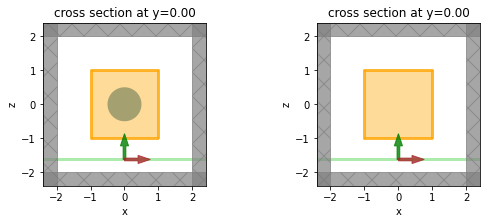

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
sim.plot(y=0, ax=ax1);
sim_empty.plot(y=0, ax=ax2);

## Run Simulations

Now we can run both simulations over time and measure the results


In [9]:
# Run simulation
import tidy3d.web as web

sim_data = web.run(sim, task_name='sphereRCS', path='data/sphereRCS.hdf5')
sim_empty_data = web.run(sim_empty, task_name='sphereRCS_empty', path='data/sphereRCS_empty.hdf5')

In [11]:
# compute scattered near fields by subtracting out the incident fields from the empty simulation
for mon in monitors_near:
    sim_data[mon.name].Ex.values -= sim_empty_data[mon.name].Ex.values
    sim_data[mon.name].Ey.values -= sim_empty_data[mon.name].Ey.values
    sim_data[mon.name].Ez.values -= sim_empty_data[mon.name].Ez.values

    sim_data[mon.name].Hx.values -= sim_empty_data[mon.name].Hx.values
    sim_data[mon.name].Hy.values -= sim_empty_data[mon.name].Hy.values
    sim_data[mon.name].Hz.values -= sim_empty_data[mon.name].Hz.values

# do the same for downsampled monitors
for mon in monitors_downsampled:
    sim_data[mon.name].Ex.values -= sim_empty_data[mon.name].Ex.values
    sim_data[mon.name].Ey.values -= sim_empty_data[mon.name].Ey.values
    sim_data[mon.name].Ez.values -= sim_empty_data[mon.name].Ez.values

    sim_data[mon.name].Hx.values -= sim_empty_data[mon.name].Hx.values
    sim_data[mon.name].Hy.values -= sim_empty_data[mon.name].Hy.values
    sim_data[mon.name].Hz.values -= sim_empty_data[mon.name].Hz.values

# also for the server-side case, compute scattered far fields by subtracting out the incident far fields from the empty simulation
sim_data[monitor_far.name].Ntheta.values -= sim_empty_data[monitor_far.name].Ntheta.values
sim_data[monitor_far.name].Nphi.values -= sim_empty_data[monitor_far.name].Nphi.values

sim_data[monitor_far.name].Ltheta.values -= sim_empty_data[monitor_far.name].Ltheta.values
sim_data[monitor_far.name].Lphi.values -= sim_empty_data[monitor_far.name].Lphi.values

[11:22:58] INFO     Auto meshing using wavelength 0.5000 defined from        ]8;id=322226;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=311008;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#473\473]8;;\
                    sources.                                                                 

           INFO     Auto meshing using wavelength 0.5000 defined from        ]8;id=289741;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=105113;file:///home/shashwat/flexcompute/repositories/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#473\473]8;;\
                    sources.                                                                 

## Setting Up the Local Near2Far Computation

To set up the near-to-far transformation locally, we need to grab the fields on each surface of the near-field [FieldMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html) objects.

So, we simply create a [RadiationVectors](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.RadiationVectors.html) object and pass in the surface monitors as shown below.  Note that we also need to pass the normal directions of each of the monitors in the list.

In addition to storing the near field data, this object will compute the surface currents and provide various methods for projecting the far field quantities.

We can optionally pass in the number of points per wavelength in the background medium with which to sample fields on the monitors. The default is 10 points per wavelength. This can reduce computation times significantly. By default, 10 points per wavelength are used.

One can also pass in coordinates for the local origin of the set of monitors; the far-field observation points will be defined with respect to this origin. By default, the local origin is set to the average of the centers of all surface monitors passed in.

To see the usefulness of downsampling the fields recorded on monitors, we'll also run the near-to-far transformation with downsampled fields to compare the RCS.

Finally, to get a sense of performance, we'll measure the time it takes to compute the radiation vectors locally, and compare it to the time it took to compute them on the server.

In [16]:
import time

# first, we construct the classes which compute radiation vectors locally on your machine
n2f = td.RadiationVectors.from_near_field_monitors(
    sim_data=sim_data, 
    near_monitors=monitors_near, # only supply the non-downsampled surface monitors as sources
    normal_dirs=['-','+','-','+','-','+'], 
    pts_per_wavelength=10
)

# do the same for the downsampled monitors
n2f_downsampled = td.RadiationVectors.from_near_field_monitors(
    sim_data=sim_data, 
    near_monitors=monitors_downsampled, # only supply the downsampled surface monitors as sources
    normal_dirs=['-','+','-','+','-','+'],  
    pts_per_wavelength=10
)

# now, we compute the radiation vectors in both cases by passing in our far field monitor from before
start = time.time()
rad_vecs = n2f.radiation_vectors(monitor_far)
end = time.time()
n2f_time = end - start

start = time.time()
rad_vecs_downsampled = n2f_downsampled.radiation_vectors(monitor_far)
end = time.time()
n2f_downsampled_time = end - start

# use the simulation log to find the time taken for server-side computations
n2f_server_time = float(sim_data.log.split("Far field computation time (s):    ", 1)[1].split("\n", 1)[0])

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Local near-to-far:  0.8597967624664307
Local near-to-far with downsampling:  0.8450198173522949
Server-side near-to-far:  0.1406


## Performance comparison

We can see below that the local computation of radiation vectors takes about the same time with and without downsampling, because the fields are anyway resampled on the near-field box prior to the computation. The real benefit of downsampling is reducing the amount of data that is stored and downloaded.

The server-side computation is extremely fast, as expected, and requires downloading no near-field data.

In [18]:
print(f"Local near-to-far: {n2f_time} s")
print(f"Local near-to-far with downsampling: {n2f_downsampled_time} s")
print(f"Server-side near-to-far: {n2f_server_time} s")

Local near-to-far: 0.8597967624664307 s
Local near-to-far with downsampling: 0.8450198173522949 s
Server-side near-to-far: 0.1406 s


## Get Far Field Data for the Server-Side Computations

Recall that we also computed scattered radiation vectors on the server; let's extract that data too.

In [13]:
rad_vecs_server = sim_data[monitor_far.name]

## Compute the RCS

Now that we have the radiation vectors computed in three different ways (locally, locally with downsampling, and remotely on the server), various far field quantities can be extracted.

For this example, we use `Near2FarAngleData.radar_cross_section()` to get the RCS at the previously-specified `theta,phi` points.

In [14]:
# get the RCS for the local, local downsampled and server-side cases
RCS = rad_vecs.radar_cross_section().sel(f=f0).values
RCS_downsampled = rad_vecs_downsampled.radar_cross_section().sel(f=f0).values
RCS_server = rad_vecs_server.radar_cross_section().sel(f=f0).values

## Plot Results
Now we can plot the RCS and compare it to the analytical RCS computed via the Mie series.

The results match very well! As expected, there are minor deviations due to approximations inherent to the near field to far field transformation.

Notice that the downsampled monitors also yield fairly accurate results with less than an eighth of the data.

/home/shashwat/flexcompute/venvs/tidy3d-core/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 540x360 with 1 Axes>

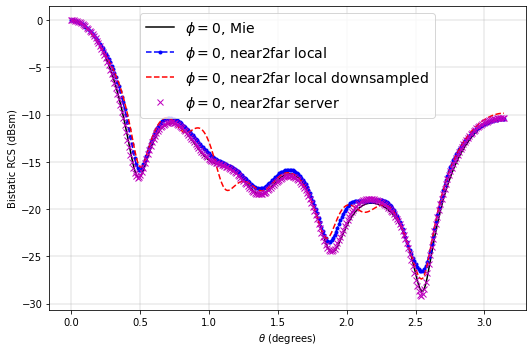

<Figure size 540x360 with 1 Axes>

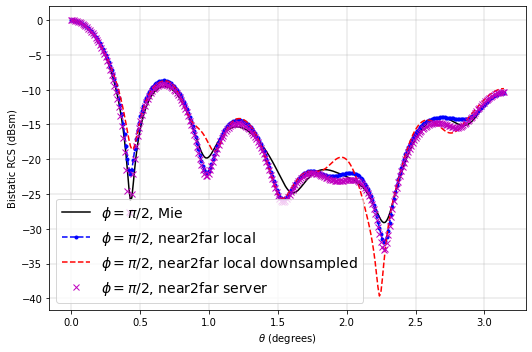

In [15]:
def to_db(val):
    val = val / np.max(np.abs(val))
    return 10.0*np.log10(val)

RCS_phi0 = RCS[:,0]
RCS_phi90 = RCS[:,1]

RCS_downsampled_phi0 = RCS_downsampled[:,0]
RCS_downsampled_phi90 = RCS_downsampled[:,1]

RCS_server_phi0 = RCS_server[:,0]
RCS_server_phi90 = RCS_server[:,1]

# ------ import analytical data from disk ------

mie_file_id = '2lambda_epsr4'
mie_filename_phi0 = "./data/mie_bRCS_phi0_" + mie_file_id + ".txt"
mie_filename_phi90 = "./data/mie_bRCS_phi90_" + mie_file_id + ".txt"

mie_data_phi0 = np.loadtxt(mie_filename_phi0, delimiter='\t', skiprows=2)
mie_theta_phi0 = np.squeeze(mie_data_phi0[:,[0]])
mie_phi0 = np.squeeze(mie_data_phi0[:,[1]])

mie_data_phi90 = np.loadtxt(mie_filename_phi90, delimiter='\t', skiprows=2)
mie_theta_phi90 = np.squeeze(mie_data_phi90[:,[0]])
mie_phi90 = np.squeeze(mie_data_phi90[:,[1]])

# ------ plot for phi = 0 ------

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_theta_phi0, to_db(mie_phi0), '-k', label="$\\phi = 0$, Mie")
ax.plot(thetas, to_db(RCS_phi0), '--.b', label="$\\phi = 0$, near2far local")
ax.plot(thetas, to_db(RCS_downsampled_phi0), '--r', label="$\\phi = 0$, near2far local downsampled")
ax.plot(thetas, to_db(RCS_server_phi0), 'xm', label="$\\phi = 0$, near2far server")
ax.set(xlabel = "$\\theta$ (degrees)",
       ylabel = "Bistatic RCS (dBsm)",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

# ------ plot for phi = pi/2 ------

fig, ax = plt.subplots(figsize=(7.5, 5))

ax.plot(mie_theta_phi90, to_db(mie_phi90), '-k', label="$\\phi = \\pi/2$, Mie")
ax.plot(thetas, to_db(RCS_phi90), '--.b', label="$\\phi = \\pi/2$, near2far local")
ax.plot(thetas, to_db(RCS_downsampled_phi90), '--r', label="$\\phi = \\pi/2$, near2far local downsampled")
ax.plot(thetas, to_db(RCS_server_phi90), 'xm', label="$\\phi = \\pi/2$, near2far server")
ax.set(xlabel = "$\\theta$ (degrees)",
       ylabel = "Bistatic RCS (dBsm)",
       yscale = 'linear',
       xscale = 'linear'
      )
ax.grid(visible = True, which = 'both', axis = 'both', linewidth = 0.4)
plt.legend(loc='best', prop={'size': 14})
plt.tight_layout()

